In [1]:
%pip install -q -U pip
%pip install -q -U networkx
%pip install -q -U matplotlib
%pip install -q -U numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import collections
import numpy as np

from custommodels.Pickle import pickle

In [2]:
#import data from file
plot_path = "../data/plots/"
path = "../data/loc-brightkite_edges.txt.gz"
G = nx.read_edgelist(path, create_using=nx.Graph(), nodetype=int)
len(G.nodes()), len(G.edges())

#for plots
green = '#94bc24'
navy = '#243444'

# Get largest component

In [3]:
largest_cc = max(nx.connected_components(G), key=len)
len(largest_cc)
G = G.subgraph(largest_cc)

In [4]:
print("Number of edges:", len(nx.edges(G)))
print("Number of nodes", len(nx.nodes(G)))
print("The average clustering coefficient for the network:", nx.average_clustering(G))
#print("The clustering coefficient for nodes", nx.clustering(G))
print("The maximum degree of the network:", max(dict(G.degree()).values()))

Number of edges: 212945
Number of nodes 56739
The average clustering coefficient for the network: 0.17337881358774052
The maximum degree of the network: 1134


In [4]:
# Calculate the degrees of all nodes and store them in a list
degrees = [degree for node, degree in G.degree()]

# Count the frequency of each degree value
degree_count = Counter(degrees)
degree, frequency = zip(*degree_count.items())
prob = [f/len(nx.nodes(G)) for f in frequency]


# Create a scatter plot of degrees (log-log scale)
plt.scatter(degree, frequency, c=green, edgecolors = navy)

# Set the x and y axis to log scale
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution on Log-Log Scale')

# save the plot
plt.savefig(plot_path + 'degree_distribution.png')
# Show the plot
plt.show()

TypeError: unsupported operand type(s) for /: 'tuple' and 'int'

Power law


In [ ]:
%pip install -q -U powerlaw

Calculating best minimal value for power law fit
2.558853351893055%
459.08354463610004 2.0314625034490142e-14
-17.1802972042953 0.0005380925030633585
-476.2638418404214 1.432682778234371e-17


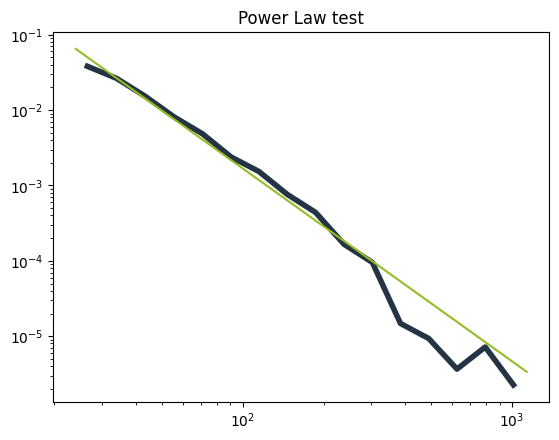

In [5]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

import powerlaw # Power laws are probability distributions with the form:p(x)∝x−α
fit = powerlaw.Fit(degree_sequence) 
fig2 = fit.plot_pdf(color= navy, linewidth=4)
fit.power_law.plot_pdf(color = green, ax=fig2)
plt.title('Power Law test')
print(fit.power_law.alpha)
plt.savefig(plot_path + 'power_law_test.png')
R_e, p_e = fit.distribution_compare('power_law', 'exponential')
R_l, p_l = fit.distribution_compare('power_law', 'lognormal')
R_el, p_el = fit.distribution_compare('exponential', 'lognormal')


print('R:'R_e, 'p-value:' p_e)
print(R_l, p_l)
print(R_el, p_el)

CCDF log log scale


In [ ]:
# finding the degree CCDF 
def degree_ccdf(graph):
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
    degree_count = collections.Counter(degree_sequence)
    degree, count = zip(*degree_count.items())
    ccdf = 1 - np.cumsum(count[::-1])[::-1]/graph.number_of_nodes()
    return degree, ccdf

# plotting the ccdf for the true graph and the random graph 
degree_G, ccdf_G  = degree_ccdf(G)
plt.figure(figsize=(8, 6))
plt.loglog(degree_G, ccdf_G, marker='o', linestyle='None',  c='#94bc24', mec = '#223747')
plt.title('Degree CCDF in Log-Log Scale')
plt.xlabel('Degree')
plt.ylabel('CCDF')
plt.savefig(plot_path + 'ccdf.png')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import powerlaw as pl
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import linregress
# Load the data and redo the CCDF.
#G = nx.read_edgelist("../4/data.txt", delimiter = "\t")
dd = Counter(dict(G.degree).values())
dd = pd.DataFrame(list(dd.items()), columns = ("k", "count")).sort_values(by = "k")
ccdf = dd.sort_values(by = "k", ascending = False)
ccdf["cumsum"] = ccdf["count"].cumsum()
ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
ccdf = ccdf[["k", "ccdf"]].sort_values(by = "k")
# We take the logarithm in base 10 of both degree and CCDF. Then we simply do a linear regression. The slope is
# the exponent. The intercept needs to be the power of 10, to undo the logarithm operation. Look at that
# r-squared!
logcdf = np.log10(ccdf[["k", "ccdf"]])
slope, log10intercept, r_value, p_value, std_err = linregress(logcdf["k"], logcdf["ccdf"])
#print("CCDF Fit: %1.4f x ^ %1.4f (R2 = %1.4f, p = %1.4f)" % (10 ** log10intercept, slope, r_value ** 2, p_value))

# With the powerlaw package, fitting the CCDf is simple. It will store results in the .power_law property. To
# get the actual k_min, we need to find the degree value corresponding to the probability in .power_law.xmin:
# pandas makes it easy. This is definitely a shifted power law. (Kappa contains the intercept information)
results = pl.Fit(ccdf["ccdf"])
k_min = ccdf[ccdf["ccdf"] == results.power_law.xmin]["k"]
#print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))

# Let's plot the best fit.
ccdf["fit"] = (10 ** results.power_law.Kappa) * (ccdf["k"] ** -results.power_law.alpha)
ax = plt.gca()
plt.loglog(degree_G, ccdf_G, marker='o', linestyle='None',  c='#94bc24', mec = '#223747')
#ccdf.plot(y = "ccdf",marker='o', linestyle='None',  c='#94bc24', mec = '#223747', loglog = True, ax = ax)
ccdf.plot(kind = "line", x = "k", y = 'fit', color = '#223747', loglog = True, ax = ax)
ax.legend().set_visible(False) 
plt.title('Degree CCDF in Log-Log Scale')
plt.xlabel('Degree')
plt.ylabel('CCDF')
plt.savefig(plot_path + 'ccdf+line.png')

Density

In [ ]:
density = nx.density(G)
density

Local clustering coefficient

In [ ]:
def clusters():
    clusters = nx.clustering(G)
    return clusters

clusters = pickle(clusters)
sorted_clusters = sorted(clusters.items(), key=lambda item: item[1], reverse = True)


In [ ]:
min(clusters.values()) , max(clusters.values())
# (0,1.0) 
plt.hist(clusters.values(), color = green)
plt.title('Clustering coefficient distribution')
plt.savefig(plot_path + 'clusters.png')
plt.show()
# most nodes have lower clustering coefficients but some also have very high clustering coefficient 

In [ ]:
avg_LCC = sum(clusters.values())/len(clusters.values())
avg_LCC

In [ ]:
# Transitivity = global clustering coefficient
transitivity = nx.transitivity(G)
transitivity

Checking the clustering coefficient with a random graph

In [6]:
#Generate a random graph with removing parallel edges and self-loops
seq = degrees
RG = nx.configuration_model(seq)
RG = nx.Graph(RG)
RG.remove_edges_from(nx.selfloop_edges(RG))

In [10]:

RG_globalCC = nx.transitivity(RG)
RG_avgCC = nx.average_clustering(RG)

print(RG_globalCC, RG_avgCC)

0.007580478697547011 0.005590676110849966


Diameter

In [ ]:
def diameter():
    diameter = nx.diameter(G)
    return diameter

diameter = pickle(diameter)
# answer = 18 
print(diameter)

Average shortest path

In [ ]:
def avg_shortest_path():
    avg_shortest_path = nx.average_shortest_path_length(G)
    return avg_shortest_path
avg_shortest_path = pickle(avg_shortest_path)
avg_shortest_path

# answer: 4.917269741932054

Shortest path distribution 

In [ ]:
# Can't run it, I don't have enough memory - Ania


def shortest_path_lengths():
    # Calculate shortest path lengths
    all_shortest_path_lengths = {}

    for node in G.nodes:
        shortest_path_lengths = nx.single_source_shortest_path_length(G, node)
        all_shortest_path_lengths[node] = shortest_path_lengths
    return all_shortest_path_lengths

# Calculate shortest paths lengths for our grapgh and store in a pickle
shortest_path_lengths = pickle(shortest_path_lengths)
print(shortest_path_lengths)

Betweenness centrality

In [6]:
def betweenness_centrality():
    betweenness_centrality = nx.betweenness_centrality(G)
    return betweenness_centrality
betweenness_centrality = pickle(betweenness_centrality)
betweenness_centrality


Found data, loading from picklejar


{0: 0.0027782250041033085,
 1: 0.00018982797729129089,
 2: 0.0010528766008397162,
 3: 0.009235643798616003,
 4: 0.00014808490951451444,
 5: 0.0004103949944709264,
 6: 0.001906570465119014,
 7: 0.006351480171032358,
 8: 1.0283058986462158e-08,
 9: 0.0002638530413067625,
 10: 0.0007663831030129757,
 11: 0.0009388170519984818,
 12: 0.001290578792613001,
 13: 0.0027401762970616556,
 14: 0.00018472200709877134,
 15: 0.0003178769520871339,
 16: 0.0004148526654272732,
 17: 0.0015359132705463293,
 18: 0.0005376652489143878,
 19: 0.000529870469721093,
 20: 0.0016452755460756858,
 21: 0.0006593984815771676,
 22: 6.928741987384659e-06,
 23: 0.000507492141230547,
 24: 0.0002742208485131949,
 25: 9.903199785339078e-05,
 26: 0.00139962411860137,
 27: 0.005417968494267295,
 28: 0.0002420307629841739,
 29: 0.0029506348828516327,
 30: 0.007011375808041959,
 31: 0.00019186631464922617,
 32: 4.167052190931295e-05,
 33: 0.0,
 34: 0.00034040194583562927,
 35: 0.02498508521877784,
 36: 0.040196157255756634,

In [7]:
between_list = []
for key, value in betweenness_centrality.items():
    between_list.append((value))
between_list


[0.0027782250041033085,
 0.00018982797729129089,
 0.0010528766008397162,
 0.009235643798616003,
 0.00014808490951451444,
 0.0004103949944709264,
 0.001906570465119014,
 0.006351480171032358,
 1.0283058986462158e-08,
 0.0002638530413067625,
 0.0007663831030129757,
 0.0009388170519984818,
 0.001290578792613001,
 0.0027401762970616556,
 0.00018472200709877134,
 0.0003178769520871339,
 0.0004148526654272732,
 0.0015359132705463293,
 0.0005376652489143878,
 0.000529870469721093,
 0.0016452755460756858,
 0.0006593984815771676,
 6.928741987384659e-06,
 0.000507492141230547,
 0.0002742208485131949,
 9.903199785339078e-05,
 0.00139962411860137,
 0.005417968494267295,
 0.0002420307629841739,
 0.0029506348828516327,
 0.007011375808041959,
 0.00019186631464922617,
 4.167052190931295e-05,
 0.0,
 0.00034040194583562927,
 0.02498508521877784,
 0.040196157255756634,
 0.000955313406901192,
 0.00014840214149364103,
 1.440310864859764e-07,
 0.12403234435146233,
 0.0003244053242493916,
 0.0018796582755743

[0.0027782250041033085, 0.00018982797729129089, 0.0010528766008397162, 0.009235643798616003, 0.00014808490951451444, 0.0004103949944709264, 0.001906570465119014, 0.006351480171032358, 1.0283058986462158e-08, 0.0002638530413067625, 0.0007663831030129757, 0.0009388170519984818, 0.001290578792613001, 0.0027401762970616556, 0.00018472200709877134, 0.0003178769520871339, 0.0004148526654272732, 0.0015359132705463293, 0.0005376652489143878, 0.000529870469721093, 0.0016452755460756858, 0.0006593984815771676, 6.928741987384659e-06, 0.000507492141230547, 0.0002742208485131949, 9.903199785339078e-05, 0.00139962411860137, 0.005417968494267295, 0.0002420307629841739, 0.0029506348828516327, 0.007011375808041959, 0.00019186631464922617, 4.167052190931295e-05, 0.0, 0.00034040194583562927, 0.02498508521877784, 0.040196157255756634, 0.000955313406901192, 0.00014840214149364103, 1.440310864859764e-07, 0.12403234435146233, 0.0003244053242493916, 0.0018796582755743552, 0.000291170873166181, 0.0034401808232

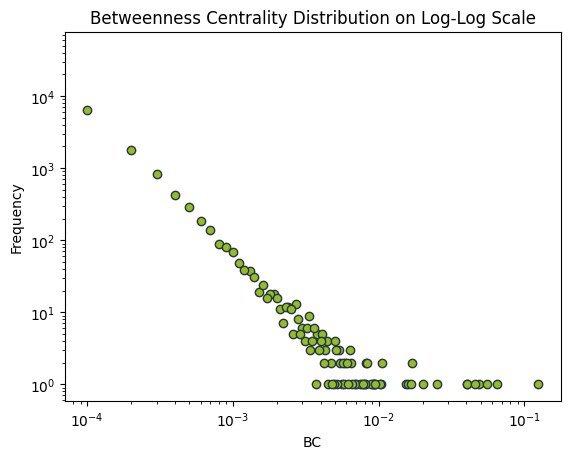

In [8]:
lists = sorted(betweenness_centrality.items()) # sorted by key, return a list of tuples
#print(lists)
between_values = list(betweenness_centrality.values())
between_val = []
print(between_values)
for item in between_values:
    item = round(item, 4)
    between_val.append(item)
print(between_val)
values_count = Counter(between_val)
between, frequency = zip(*values_count.items())


plt.scatter(between, frequency, c=green, edgecolors = navy)
# Set the x and y axis to log scale
plt.xscale('log')
plt.yscale('log')

plt.xlabel('BC')
plt.ylabel('Frequency')
plt.title('Betweenness Centrality Distribution on Log-Log Scale')
plt.savefig(plot_path + 'betwenness.png')


Degree distribution dictionary

In [17]:
def sorted_degree():
    degree_dict = dict(G.degree)
    sorted_degree = (sorted(degree_dict.items(), key=lambda item: item[1], reverse = True))
    return sorted_degree

sorted_degree = pickle(sorted_degree)
print(sorted_degree)

Found data, loading from picklejar
[(40, 1134), (44, 1055), (108, 854), (116, 838), (159, 833), (36, 779), (191, 732), (49, 569), (634, 550), (156, 475), (35, 467), (207, 453), (651, 448), (3245, 404), (250, 386), (2625, 379), (1093, 354), (163, 343), (405, 337), (833, 334), (1100, 333), (27, 332), (212, 327), (112, 326), (6365, 325), (1302, 321), (214, 311), (148, 310), (102, 306), (146, 301), (209, 299), (6991, 296), (1076, 292), (446, 289), (1878, 282), (719, 274), (195, 272), (2812, 271), (176, 270), (1143, 270), (2349, 270), (210, 267), (2896, 267), (1875, 266), (143, 264), (3, 259), (6895, 257), (7170, 256), (30, 254), (676, 253), (2904, 253), (2850, 248), (680, 242), (241, 241), (7, 230), (10346, 230), (174, 228), (1082, 228), (2829, 228), (1386, 227), (1877, 226), (2953, 225), (6923, 225), (2893, 221), (620, 218), (2314, 218), (901, 215), (262, 214), (2880, 214), (6640, 213), (13909, 213), (6589, 212), (301, 211), (144, 210), (161, 210), (229, 210), (1876, 210), (168, 209), (18

[[1.         0.70493314]
 [0.70493314 1.        ]]


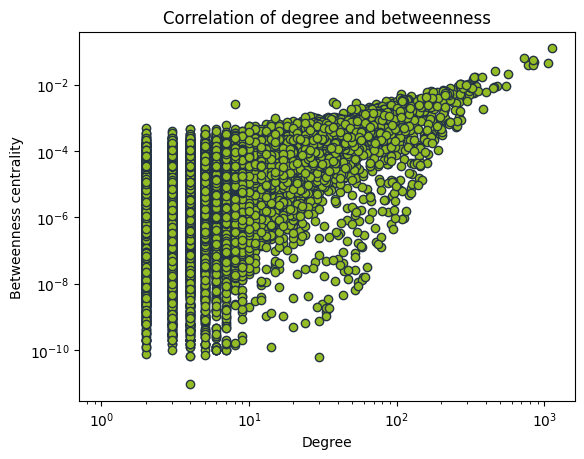

In [36]:

import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

# Sample data
x = [i[1] for i in sorted(sorted_degree, key = lambda x: x[0])]
y = [i[1] for i in lists]


plt.scatter(x, y, c=green, edgecolors = navy)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Betweenness centrality')
plt.title('Correlation of degree and betweenness')

corr = np.corrcoef(x, y)
plt.savefig(plot_path + 'correlation.png')
print(corr)
plt.show()